# 2d contacts

Author: Jukka Aho

Abstract: 2d tie contact.

## Model 1: three body tie contact


![model](http://s4.postimg.org/u9yqeryul/Screenshot_from_2015_11_24_02_00_00.png)

Each element is modelled as own "body" and they are connected using tie contacts. Segments 5-6 and 9-10 and 6-7 are slave surfaces, so node 6 or 9 is on at least two tie contacts as slave node. Moreover this model has dirichlet boundary $y=0$ at bottom of body 1 and $x=0$ on left. To get the accurate solution one needs to minimize 
\begin{equation}
\frac{15}{2}u_1^4 + 60 u_1^3 + \frac{15}{4}u_1^2 u_2^2 + 15 u_1^2 u_2 + 120 u_1^2 + 15 u_1 u_2^2 + 60 u_1 u_2 + \frac{15}{2}u_2^4 + 60 u_2^3 + 120 u_2^2 + 50 u_2,
\end{equation}
which gives approximate $u_1 = 0.0634862$ and $u_2 = -0.277183$ for the displacement of upper right corner.
[Wolfram](http://www.wolframalpha.com/input/?i=local+minimum+15*x^4%2F2+%2B+60*x^3+%2B+15*x^2*y^2%2F4+%2B+15*x^2*y+%2B+120*x^2+%2B+15*x*y^2+%2B+60*x*y+%2B+15*y^4%2F2+%2B+60*y^3+%2B+120*y^2+%2B+50*y).

In [1]:
using JuliaFEM.Core: Element, Seg2, Quad4, PlaneStressElasticityProblem,
                     DirichletProblem, MortarProblem, DirectSolver

In [10]:
nodes = Dict{Int64, Vector{Float64}}(
    1 => [0.0, 0.0], 2 => [2.0, 0.0],
    3 => [2.0, 1.0], 4 => [0.0, 1.0],
    5 => [0.0, 1.0], 6 => [1.0, 1.0],
    7 => [1.0, 2.0], 8 => [0.0, 2.0],
    9 => [1.0, 1.0], 10 => [2.0, 1.0],
    11 => [2.0, 2.0], 12 => [1.0, 2.0]);

In [11]:
connectivity = Dict{Int64, Vector{Int64}}(
    1 => [1, 2, 3, 4],
    2 => [5, 6, 7, 8],
    3 => [9, 10, 11, 12]);

In [13]:
elements = Element[]
for c in values(connectivity)
    element = Quad4(c)
    element["geometry"] = Vector{Float64}[nodes[i] for i in c]
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    push!(elements, element)
end
nelements = length(elements)
info("number of elements: $nelements")

INFO: number of elements: 3


Create three bodies, each containing one element.

In [14]:
body1 = PlaneStressElasticityProblem("body 1")
body2 = PlaneStressElasticityProblem("body 2")
body3 = PlaneStressElasticityProblem("body 3")
push!(body1, elements[1])
push!(body2, elements[2])
push!(body3, elements[3]);

Surface traction to the top of bodies 2 and 3:

In [15]:
t2 = Seg2([8, 7])
t2["geometry"] = Vector{Float64}[nodes[8], nodes[7]]
t2["displacement traction force"] = Vector{Float64}[[0.0, -100.0], [0.0, -100.0]]
t3 = Seg2([12, 11])
t3["geometry"] = Vector{Float64}[nodes[12], nodes[11]]
t3["displacement traction force"] = Vector{Float64}[[0.0, -100.0], [0.0, -100.0]]
push!(body2, t2)
push!(body3, t3);

Boundary conditions: $x=0$ for left boundary.

In [16]:
dx1 = Seg2([1, 4])
dx1["geometry"] = Vector[nodes[1], nodes[4]]
dx1["displacement 1"] = 0.0
dx2 = Seg2([5, 8])
dx2["geometry"] = Vector[nodes[5], nodes[8]]
dx2["displacement 1"] = 0.0
bc1 = DirichletProblem("displacement", 2)
push!(bc1, dx1)
push!(bc1, dx2);

$y=0$ for bottom of model

In [17]:
dy1 = Seg2([1, 2])
dy1["geometry"] = Vector[nodes[1], nodes[2]]
dy1["displacement 2"] = 0.0
bc2 = DirichletProblem("displacement", 2)
push!(bc2, dy1);

Mortar boundary conditions: tie contact between body 1 and body 2

In [19]:
#rotation_matrix(phi) = [cos(phi) -sin(phi); sin(phi) cos(phi)]
using JuliaFEM.Core: calculate_normal_tangential_coordinates!

master1 = Seg2([4, 3])
master1["geometry"] = Vector[nodes[4], nodes[3]]
slave1 = Seg2([5, 6])
slave1["geometry"] = Vector[nodes[5], nodes[6]]
slave1["master elements"] = Element[master1]
calculate_normal_tangential_coordinates!(slave1, 0.0)

#slave1["nodal ntsys"] = Matrix[rotation_matrix(-pi/2), rotation_matrix(-pi/2)]
contact1 = MortarProblem("displacement", 2)
push!(contact1, slave1);

Tie contact between body 1 and body 3

In [20]:
slave2 = Seg2([9, 10])
slave2["geometry"] = Vector[nodes[9], nodes[10]]
#slave2["nodal ntsys"] = Matrix[rotation_matrix(-pi/2), rotation_matrix(-pi/2)]
slave2["master elements"] = Element[master1]
calculate_normal_tangential_coordinates!(slave2, 0.0)
contact2 = MortarProblem("displacement", 2)
push!(contact2, slave2);

Tie contact between body 2 and body 3

In [21]:
master2 = Seg2([6, 7])
master2["geometry"] = Vector[nodes[6], nodes[7]]
slave3 = Seg2([9, 12])
slave3["geometry"] = Vector[nodes[9], nodes[12]]
#slave3["nodal ntsys"] = Matrix[rotation_matrix(0.0), rotation_matrix(0.0)]
calculate_normal_tangential_coordinates!(slave3, 0.0)
slave3["master elements"] = Element[master2]
contact3 = MortarProblem("displacement", 2)
push!(contact3, slave3);

All defined. Solve it.

In [22]:
solver = DirectSolver()
push!(solver, body1)
push!(solver, body2)
push!(solver, body3)
push!(solver, bc1)
push!(solver, bc2)
push!(solver, contact1)
push!(solver, contact2)
push!(solver, contact3);

In [23]:
iterations, converged = call(solver, 0.0)

INFO: Starting solver DirectSolver
INFO: # of field problems: 3
INFO: # of boundary problems: 5
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: body 1
INFO: Assembling body 2: body 2
INFO: Assembling body 3: body 3
INFO: dim = 24
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary
INFO: Assembling boundary 2: dirichlet boundary
INFO: Assembling boundary 3: mortar problem
INFO: Assembling boundary 4: mortar problem
INFO: Assembling boundary 5: mortar problem
INFO: Solving system
INFO: UMFPACK: solved in 0.3197059631347656 seconds. norm = 0.5357583756107197
INFO: timing info for iteration:
INFO: boundary assembly       : 0.3747282028198242
INFO: field assembly          : 2.646785020828247
INFO: dump matrices to disk   : 9.5367431640625e-7
INFO: solve problem           : 0.4615659713745117
INFO: update element data     : 0.02040410041809082
INFO: non-linear iteration    : 3.5035040378570557
INFO: Starting iteration 2

(5,true)

INFO: boundary assembly       : 0.035440921783447266
INFO: field assembly          : 0.0363919734954834
INFO: dump matrices to disk   : 0.0
INFO: solve problem           : 0.06740903854370117
INFO: update element data     : 0.0001380443572998047
INFO: non-linear iteration    : 0.13939404487609863
INFO: solver finished in 4.193101167678833 seconds.


In [24]:
using JuliaFEM.Test

@test converged

X = elements[2]("geometry", [1.0, 1.0], 0.0)
u = elements[2]("displacement", [1.0, 1.0], 0.0)
info("displacement at $X = $u")
@test isapprox(u, [0.0634862, -0.277183], atol=1.0e-5)

INFO: displacement at [2.0,2.0] = [0.06348623177789363,-0.2771830378556528]


Test Passed
  Expression: isapprox(u,[0.0634862,-0.277183],atol=1.0e-5)

## Model 2: splitted beam, tie contact

<img src="http://results.juliafem.org/splitted-2d-beam/2015-12-22-splitted-beam-mesh.png">

Put some load on the top, dx=dy=0 on left boundary.

In [1]:
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: PlaneStressLinearElasticityProblem, DirichletProblem,
                     get_connectivity, Quad4, Tri3, Seg2, LinearSolver,
                     update!, get_elements

In [7]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

phi = pi/4
rmat = [cos(phi) -sin(phi); sin(phi) cos(phi)]

function create_problems()

    mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/2d_beam/BEAM.med")
    
    for (k, v) in mesh["nodes"]
        mesh["nodes"][k] = rmat*v
    end
    
    field_problem = PlaneStressLinearElasticityProblem()

    # field problems
    joo = Dict(:QU4 => Quad4, :TR3 => Tri3)
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype in keys(joo) || continue
        element = joo[eltype](elcon)
        update!(element, "geometry", mesh["nodes"])
        element["youngs modulus"] = 900.0
        element["poissons ratio"] = 0.25
        push!(field_problem, element)
    end

    # neumann boundary condition -1 on y direction
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == :LOAD || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        # FIXME
        # element["displacement traction force"] = rmat*[0.0, -0.01]
        f = rmat*[0.0, -0.01]
        element["displacement traction force"] = Vector{Float64}[f, f]
        push!(field_problem, element)
    end

    # boundary conditions
    boundary_problem = DirichletProblem("displacement", 2)

    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == :LEFT || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        element["displacement"] = 0.0
        push!(boundary_problem, element)
    end

    info("created $(length(get_elements(field_problem))) field elements.")
    info("created $(length(get_elements(boundary_problem))) boundary elements.")

    # Contact definition: contact pair is `LOWER_TO_UPPER <--> UPPER_TO_LOWER`:

    mortar_surface = :UPPER_TO_LOWER
    slave_surface = :LOWER_TO_UPPER

    master_elements = JuliaFEM.Core.Element[]
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == mortar_surface || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        push!(master_elements, element)
    end

    contact_problem = MortarProblem("displacement", 2)
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        eltype == :SE2 || continue
        elset == slave_surface || continue
        element = Seg2(elcon)
        update!(element, "geometry", mesh["nodes"])
        element["master elements"] = master_elements
        calculate_normal_tangential_coordinates!(element, 0.0)
        push!(contact_problem, element)
    end

    info("# of master elements: $(length(master_elements))")
    info("# of slave elements: $(length(contact_problem.elements))")

    return field_problem, boundary_problem, contact_problem

end

create_problems (generic function with 1 method)

In [8]:
using JuliaFEM.Core: DirectSolver

field_problem, boundary_problem, contact_problem = create_problems()

solver = DirectSolver()
solver.name = "divided_beam"
solver.method = :UMFPACK
solver.max_iterations = 3
solver.dump_matrices = false
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)

INFO: Found 5 element sets: LOWER_TO_UPPER, RIGHT, UPPER_TO_LOWER, LEFT, LOAD
INFO: created 104 field elements.
INFO: created 4 boundary elements.
INFO: # of master elements: 14
INFO: # of slave elements: 20
INFO: Starting solver divided_beam
INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: plane stress linear elasticity
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 210
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary
INFO: Assembling boundary 2: mortar problem
INFO: Solving system
INFO: UMFPACK: solved in 0.32906603813171387 seconds. norm = 1.0493886213441448
INFO: timing info for iteratio

(2,true)

INFO: timing info for iteration:
INFO: boundary assembly       : 0.09813404083251953
INFO: field assembly          : 0.05019092559814453
INFO: dump matrices to disk   : 9.5367431640625e-7
INFO: solve problem           : 0.07112407684326172
INFO: update element data     : 0.0012018680572509766
INFO: non-linear iteration    : 0.22066807746887207
INFO: solver finished in 2.829770088195801 seconds.


In [9]:
import PyPlot

INFO: displacement at tip: [0.12002620186301985,-0.15542771506722675]


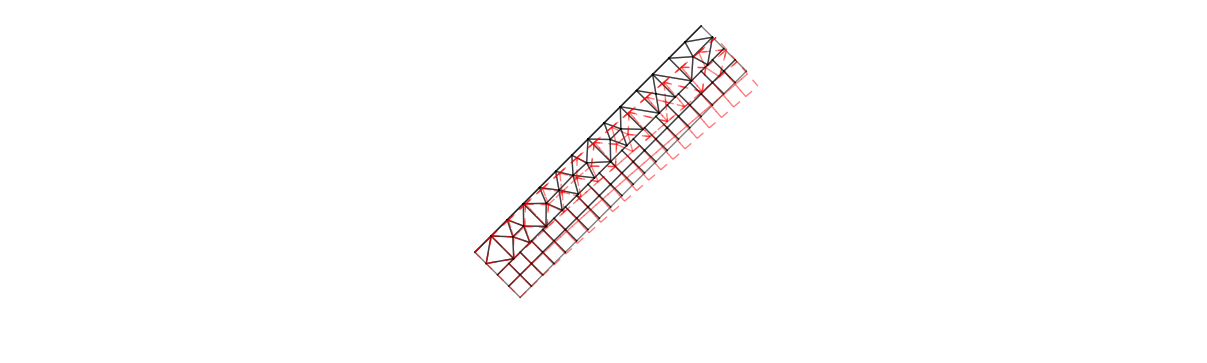

2-element Array{Float64,1}:
  0.120026
 -0.155428

In [10]:
function plot(field_problem, scaling_factor=30, time=0.0)

    fig = PyPlot.figure(figsize=(15, 4))

    g_tip = rmat*[100.0, 0.0]
    u_tip = nothing
    
    for element in field_problem.elements
        conn = get_connectivity(element)
        X = element("geometry", time)
        u = element("displacement", time)
        x = X + scaling_factor*u
        if isapprox(element("geometry", [1.0, -1.0], time), g_tip)
            u_tip = element("displacement", [1.0, -1.0], time)
            info("displacement at tip: $u_tip")
        end

        # undeformed
        for i=1:length(X)
            px1 = X[i][1]
            py1 = X[i][2]
            px2 = X[mod(i,length(X))+1][1]
            py2 = X[mod(i,length(X))+1][2]
            PyPlot.plot([px1, px2], [py1, py2], "k-", alpha=0.5)
        end

        # deformed
        for i=1:length(x)
            px1 = x[i][1]
            py1 = x[i][2]
            px2 = x[mod(i,length(x))+1][1]
            py2 = x[mod(i,length(x))+1][2]
            PyPlot.plot([px1, px2], [py1, py2], "r--", alpha=0.5)
        end
    end

    PyPlot.axis("equal")
    PyPlot.axis("off")

    return u_tip
end

u_tip = plot(field_problem)

In [11]:
norm(u_tip)

0.19637735038614154

In [7]:
isapprox(u_tip, [-0.025032650050963334,-0.19477533256579582]) || warn("different result")

true

In [12]:
isapprox(norm(u_tip), 0.19637735038616433)

true

## Model 3: splitted beam, frictionless contact, small sliding

Modification to the above: allow beams to slide in tangential direction without a friction. Global assembly operator can be modified by writing own functions `preprocess_assembly!` and `postprocess_assembly!`. Here we simply remove all kinematic constraints in tangential direction to achieve frictionless sliding between bodies.

INFO: Found 5 element sets: LOWER_TO_UPPER, RIGHT, UPPER_TO_LOWER, LEFT, LOAD
INFO: created 104 field elements.
INFO: created 4 boundary elements.
INFO: # of master elements: 14
INFO: # of slave elements: 20
INFO: Starting solver divided_beam_small_sliding_contact
INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: plane stress linear elasticity
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 210
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary
INFO: Assembling boundary 2: mortar problem
INFO: assemble: doing postprocess for problem JuliaFEM.Core.BoundaryProblem{JuliaFEM.Core.MortarProblem} asse

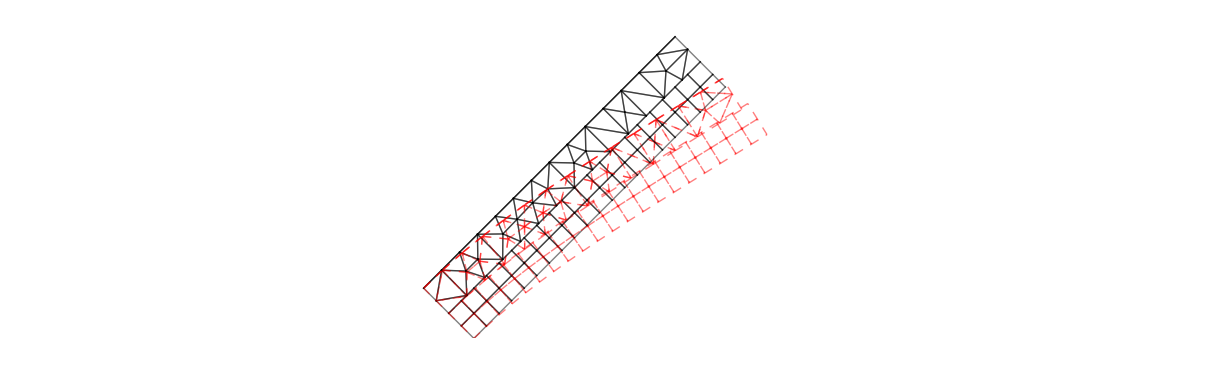

In [13]:
using JuliaFEM.Core: SparseMatrixCOO, Element, get_integration_points, get_jacobian, get_connectivity, add!
using JuliaFEM.Core: BoundaryAssembly, BoundaryProblem, get_elements

function calculate_normal_tangential_coordinates(elements::Vector{Element}, time::Real)
    P = SparseMatrixCOO()
    field_dim = 2
    for element in elements
        for ip in get_integration_points(element, Val{2})
            J = get_jacobian(element, ip, time)
            w = ip.weight*norm(J)
            nt = transpose(element("normal-tangential coordinates", ip, time))
            normal = nt[1,:]
            tangent = nt[2,:]
            for nid in get_connectivity(element)
                ndofs = [2*(nid-1)+1, 2*(nid-1)+2]
                add!(P, [2*(nid-1)+1], ndofs, normal)
                add!(P, [2*(nid-1)+2], ndofs, tangent)
            end
        end
    end
    P = sparse(P)
    for i=1:size(P,1)
        if sum(abs(P[i,:])) > 0.0
            P[i,:] = P[i,:] / norm(P[i,:])
        end
    end
    return P
end

import JuliaFEM.Core: postprocess_assembly!

function JuliaFEM.Core.postprocess_assembly!(
    assembly::BoundaryAssembly, problem::BoundaryProblem{MortarProblem},
    time::Real)
    info("postprocess mortar assembly: remove contraints in tangent direction on boundary.")

    C1 = sparse(assembly.C1)
    C2 = sparse(assembly.C2)
    info("dim of C1 = ", size(C1))
    info("dim of C2 = ", size(C2))
    dim = size(C1, 1)

    P = calculate_normal_tangential_coordinates(get_elements(problem), time)
    #P = full(P)
    #P[abs(P) .< 1.0e-9] = 0
    #P = sparse(-P)
    info("dim of P = ", size(P))
    C1 = P*C1
    C2 = P*C2

    for i=2:2:dim
        C1[i,:] = 0
        C2[i,:] = 0
    end

    #for i=1:2:dim
    #    info("normal direction in node: i=$i, ", P[i,i:i+1])
    #    info("# nonzeros in row: ", length(nonzeros(P[i,:])))
    #end

    assembly.C1 = C1
    assembly.C2 = C2
    info("postprocess mortar assembly: done.")
end


field_problem, boundary_problem, contact_problem = create_problems()
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "divided_beam_small_sliding_contact"
solver.method = :UMFPACK
solver.max_iterations = 3
solver.dump_matrices = false
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)


u_tip = plot(field_problem, 30)
isapprox(u_tip, [-0.03903778814766088,-0.5899441561142401]) || warn("result changed")
# [-0.039030212458572940,-0.5885059481026573]
# [-0.039036748287580560,-0.5897457086352924]
# [-0.039037269987308750,-0.5898452701000865]
# [-0.039037788147688480,-0.5899441561146597]
# [-0.039099099865037394,-0.5906742308544110]
# [-0.039099231221552275,-0.5907858076472083]
# [-0.039099285443584080,-0.5908044797337564]
# [-0.039149880055252856,-0.5916839898102431]
# [-0.039149700806172030,-0.5917487545114570]
# [-0.039149456207397196,-0.5918347268056199]
# [-0.039148982216695556,-0.5920462890915309]
# [-0.039148229226873680,-0.5923403595745590]

In [15]:
norm([-0.039148229226873680,-0.5923403595745590]), norm([0.39054101395962204,-0.44586724992142107])

(0.5936326182349801,0.5927224376865623)

## Simple test case, sliding contact

In [1]:
using JuliaFEM.Core: Seg2, Tri3, Quad4, Node, update!,
    calculate_normal_tangential_coordinates!, PlaneStressLinearElasticityProblem, 
    ContactProblem, SmallSlidingContact, Element
using JuliaFEM.Core: PlaneStressLinearElasticityProblem, DirichletProblem,
                     get_connectivity, Quad4, Tri3, Seg2, LinearSolver,
                     update!, get_elements, BiorthogonalBasis, StandardBasis
nodes = Dict{Int64, Node}(
    1 => [0.0, 2.0],
    2 => [2.0, 6.0],
    3 => [2.0, 2.0],
    4 => [2.0, 4.0],
    5 => [0.0, 0.0],
    6 => [2.0, 0.0],
    7 => [2.0, 0.0],
    8 => [4.0, 0.0])

Dict{Int64,Array{Float64,1}} with 8 entries:
  7 => [2.0,0.0]
  4 => [2.0,4.0]
  2 => [2.0,6.0]
  3 => [2.0,2.0]
  5 => [0.0,0.0]
  8 => [4.0,0.0]
  6 => [2.0,0.0]
  1 => [0.0,2.0]

In [2]:
basis = StandardBasis

el1 = Quad4([5, 6, 3, 1])
el2 = Tri3([1, 3, 4])
el3 = Tri3([7, 8, 2])
del1 = Seg2([5, 6])
del2 = Seg2([7, 8])
sel1 = Seg2([4, 3])
sel2 = Seg2([3, 6])
mel1 = Seg2([2, 7])
update!([el1, el2, el3, sel1, sel2, mel1, del1, del2], "geometry", nodes)
for el in [el1, el2, el3]
    el["youngs modulus"] = 90.0
    el["poissons ratio"] = 0.25
end
for el in [del1, del2]
    el["displacement"] = 0.0
end
for el in [sel1, sel2]
    el["master elements"] = Element[mel1]
    calculate_normal_tangential_coordinates!(el, 0.0)
end
prob = PlaneStressLinearElasticityProblem()
push!(prob, el1, el2, el3)
bc = DirichletProblem("displacement", 2; basis=basis)
push!(bc, del1, del2)
con = ContactProblem("cont", "displacement", 2;
                     contact_type=SmallSlidingContact)
push!(con, sel1, sel2);

In [3]:
ass1 = assemble(prob, 0.0)
dbc = assemble(bc, 0.0)
cbc = assemble(con, 0.0)

INFO: slave dofs of element: [7,8,5,6]


normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 

INFO: slave dofs of element: [5,6,11,12]


JuliaFEM.Core.BoundaryAssembly(JuliaFEM.Core.SparseMatrixCOO([7,5,7,5,7,5,7,5,8,6  …  5,11,6,12,6,12,6,12,6,12],[7,7,5,5,3,3,13,13,8,8  …  13,13,6,6,12,12,4,4,14,14],[0.21522,0.0105929,0.0105929,0.000521371,-0.147011,-0.00723572,-0.0788018,-0.00387854,0.21522,0.0105929  …  -0.0109405,-0.222282,0.000521371,0.0105929,0.0105929,0.21522,-0.00017379,-0.00353096,-0.0109405,-0.222282]),JuliaFEM.Core.SparseMatrixCOO([7,5,7,5,7,5,7,5,8,6  …  5,11,6,12,6,12,6,12,6,12],[7,7,5,5,3,3,13,13,8,8  …  13,13,6,6,12,12,4,4,14,14],[0.21522,0.0105929,0.0105929,0.000521371,-0.147011,-0.00723572,-0.0788018,-0.00387854,0.21522,0.0105929  …  -0.0109405,-0.222282,0.000521371,0.0105929,0.0105929,0.21522,-0.00017379,-0.00353096,-0.0109405,-0.222282]),JuliaFEM.Core.SparseMatrixCOO(Int64[],Int64[],Float64[]),JuliaFEM.Core.SparseMatrixCOO(Int64[],Int64[],Float64[]))


[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]
normal tangential = 
[1.0 0.0
 0.0 -1.0]


In [4]:
K = full(ass1.stiffness_matrix)
dims = size(K)
K[1:8,1:8]

8x8 Array{Float64,2}:
  92.0  -15.0  0.0   0.0  -74.0   15.0    0.0  -12.0
 -15.0   62.0  0.0   0.0   15.0  -14.0  -18.0    0.0
   0.0    0.0  6.0   0.0    0.0    0.0    0.0    0.0
   0.0    0.0  0.0  16.0    0.0    0.0    0.0    0.0
 -74.0   15.0  0.0   0.0  110.0  -15.0  -18.0   12.0
  15.0  -14.0  0.0   0.0  -15.0  110.0   18.0  -48.0
   0.0  -18.0  0.0   0.0  -18.0   18.0   18.0    0.0
 -12.0    0.0  0.0   0.0   12.0  -48.0    0.0   48.0

In [6]:
fixed = [9, 10, 11, 12, 13, 14, 15, 16]
ENV["COLUMNS"] = 300
C1 = full(cbc.C1, dims...)
C1[abs(C1) .< 1.0e-9] = 0
#C1[fixed, fixed] = 0
C1*18

16x16 Array{Float64,2}:
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0  -12.0    0.0  24.0   0.0   6.0   0.0  0.0  0.0   6.0   0.0  -24.0    0.0  0.0  0.0
 0.0  0.0    0.0  -12.0   0.0  24.0   0.0   6.0  0.0  0.0   0.0   6.0    0.0  -24.0  0.0  0.0
 0.0  0.0  -10.0    0.0   6.0   0.0  12.0   0.0  0.0  0.0   0.0   0.0   -8.0    0.0  0.0  0.0
 0.0  0.0    0.0  -10.0   0.0   6.0   0.0  12.0  0.0  0.0   0.0   0.0    0.0   -8.0  0.0  0.0
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0    0.0    0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  0.0
 0.0  0.0   -2.0    0.0   6.0   0.0 

In [7]:
D = full(cbc.D, dims...)
D[abs(D) .< 1.0e-9] = 0
D[fixed, fixed] = 0
D

16x16 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [8]:
C2 = full(cbc.C2, dims...)
C2[abs(C2) .< 1.0e-9] = 0
#C2[fixed, :] = 0
for i=2:2:16
    C1[i,:] = 0
    C2[i,:] = 0
end
C2*18

16x16 Array{Float64,2}:
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0  -12.0  0.0  24.0  0.0   6.0  0.0  0.0  0.0   6.0  0.0  -24.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0  -10.0  0.0   6.0  0.0  12.0  0.0  0.0  0.0   0.0  0.0   -8.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0  0.0  0.0
 0.0  0.0   -2.0  0.0   6.0  0.0   0.0  0.0  0.0  0.0  12.0  0.0  -16.0  0.0  0.0  0.0
 0.0  0.0    0.0  0

In [9]:
D

16x16 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [10]:
DC1 = full(dbc.C1, dims...)
DC2 = full(dbc.C2, dims...)
DD = full(dbc.D, dims...)
DC1*18

16x16 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  12.0   0.0   6.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  12.0   0.0   6.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   6.0   0.0  12.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.

In [11]:
f = zeros(16)
f[1] = 18.0
g = zeros(16)
A = [K (C1+DC1)'; (C2+DC2) (D+DD)]
b = [f; g]

32-element Array{Float64,1}:
 18.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮  
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [12]:
for i=1:size(A,1)
    if sum(abs(A[i,:])) == 0
        info("zero line $i")
        A[i,i] = 1.0
    end
end

INFO: zero line 17
INFO: zero line 18
INFO: zero line 19
INFO: zero line 20
INFO: zero line 22
INFO: zero line 24


In [13]:
u = A \ b
u = reshape(u, 2, 16)
u[abs(u) .< 1.0e-9] = 0
disp = u[:,1:8]

2x8 Array{Float64,2}:
 0.406155  0.659049   0.219683   0.439366   0.0  0.0  0.0  0.0
 0.149452  0.0       -0.102834  -0.0562157  0.0  0.0  0.0  0.0

In [24]:
# tie contact
@assert isapprox(norm(vec(disp)), 0.8223229928825583)

In [19]:
# frictionless sliding
@assert isapprox(norm(vec(disp)), 0.9363129098080032)

In [15]:
X = [0.0 2; 2 6; 2 2; 2 4; 0 0; 2 0; 2 0; 4 0]'

2x8 Array{Float64,2}:
 0.0  2.0  2.0  2.0  0.0  2.0  2.0  4.0
 2.0  6.0  2.0  4.0  0.0  0.0  0.0  0.0

In [16]:
x = X + disp

2x8 Array{Float64,2}:
 0.406155  2.65905  2.21968  2.43937  0.0  2.0  2.0  4.0
 2.14945   6.0      1.89717  3.94378  0.0  0.0  0.0  0.0

In [17]:
eldofs = Dict()
eldofs[1] = [5, 6, 3, 1]
eldofs[2] = [1, 3, 4]
eldofs[3] = [7, 8, 2]

3-element Array{Int64,1}:
 7
 8
 2

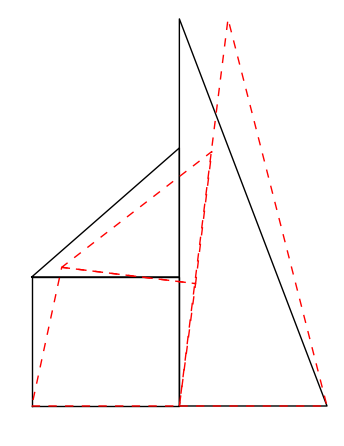

(-0.1,6.1)

In [18]:
using PyPlot

function get_coords(X)
    return [X X[:, 1]]
end

function plot(X, args...; kwargs...)
    X1 = X[:, eldofs[1]]
    X2 = X[:, eldofs[2]]
    X3 = X[:, eldofs[3]]
    PyPlot.plot(get_coords(X1)[1,:]', get_coords(X1)[2,:]', args...; kwargs...)
    PyPlot.plot(get_coords(X2)[1,:]', get_coords(X2)[2,:]', args...; kwargs...)
    PyPlot.plot(get_coords(X3)[1,:]', get_coords(X3)[2,:]', args...; kwargs...)
    axis("off")
end
figure(figsize=(4, 5))
plot(X, "-k")
plot(x, "--r")
xlim(-0.1, 4.1)
ylim(-0.1, 6.1)